In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import string
import json
from itertools import chain, islice
from collections import deque

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

In [5]:
with open('eval/RTS17/topics.json') as f:
    topics = json.load(f)
topics = [topics[-22], topics[2]]
queries = [t['title'] for t in topics]

In [6]:
qrels = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

qrels = qrels[['RTS212', 'RTS48']]

qrels = pd.concat([qrels], axis=1, keys=['Relevance'])

In [7]:
point = pd.read_csv(
    'eval/RTS17/gundog/ngram-length(3)_keep-spam(0)_language(en)_extract_retweets(0).point',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'score'],
    usecols=['topic', 'tweet_id', 'score'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

point = pd.concat([point], axis=1, keys=['Score'])

point = point.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)

/diskp/dnm11/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
point.size

24519140

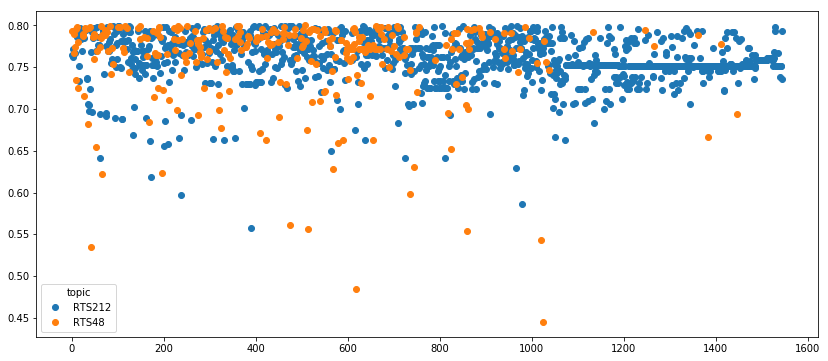

In [9]:
(
    point['Score'].apply(np.vectorize(lambda v: v if v < 0.80 else None)).dropna(how='all')
    .plot(style='o', use_index=False, figsize=(14, 6))
);

In [10]:
point.sort_values(
    [
        ('Score', 'RTS212'),
        ('Score', 'RTS48'),
        ('Relevance', 'RTS212'),
        ('Relevance', 'RTS48'),
    ][0],
    ascending=True,
)[:10]

Score           Relevance      
topic                 RTS212     RTS48    RTS212 RTS48
tweet_id                                              
892743878482292736  0.557956  1.000000       1.0   NaN
893883701536452610  0.585927  1.000000       NaN   NaN
892071967725146112  0.597213  1.000000       1.0   NaN
891780560066105345  0.618937  1.000000      -2.0   NaN
893863283677069312  0.628922  0.963698       NaN   NaN
891423725467430912  0.641077  1.000000      -2.0   NaN
893585985673588737  0.641536  0.960178       NaN   NaN
893534538340720640  0.641570  0.960203       NaN   NaN
893210738055143428  0.649866  1.000000       NaN   NaN
891923963349131264  0.655099  0.955032       1.0   NaN

In [11]:
relevance_score_by_topic = point.dropna('rows', how='all', subset=[('Relevance', 'RTS212'), ('Relevance', 'RTS48')]).fillna(-3)

relevance_score_by_topic.columns.names = ['Type', 'Topic']

relevance_score_by_topic = relevance_score_by_topic.stack('Topic').reset_index('Topic')

In [12]:
point['Relevance'].apply(lambda c: c.value_counts())

Topic,RTS212,RTS48
-2.0,52.0,46
0.0,701.0,522
1.0,121.0,44
2.0,NaN,11


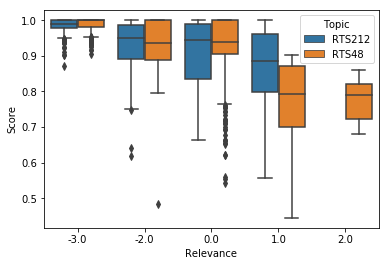

In [13]:
sns.boxplot(data=relevance_score_by_topic, x='Relevance', y='Score', hue='Topic');

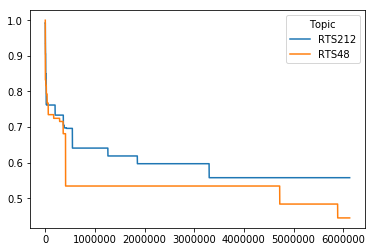

In [14]:
point['Score'].cummin().plot(use_index=False);

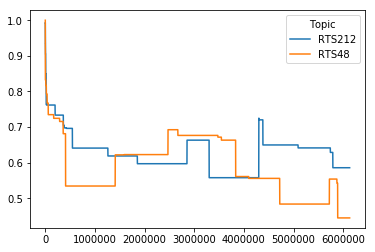

In [15]:
point['Score'].rolling(1_000_000, min_periods=1).min().plot(use_index=False);